(Ex. 1) Total Input Energy: 469.58 kWh
(Ex. 2) Average Pump Efficiency: 71.87 %
(Ex. 3) Unused Energy (Losses): 132.09 kWh
(Ex. 4) Total Hydraulic Energy: 337.49 kWh


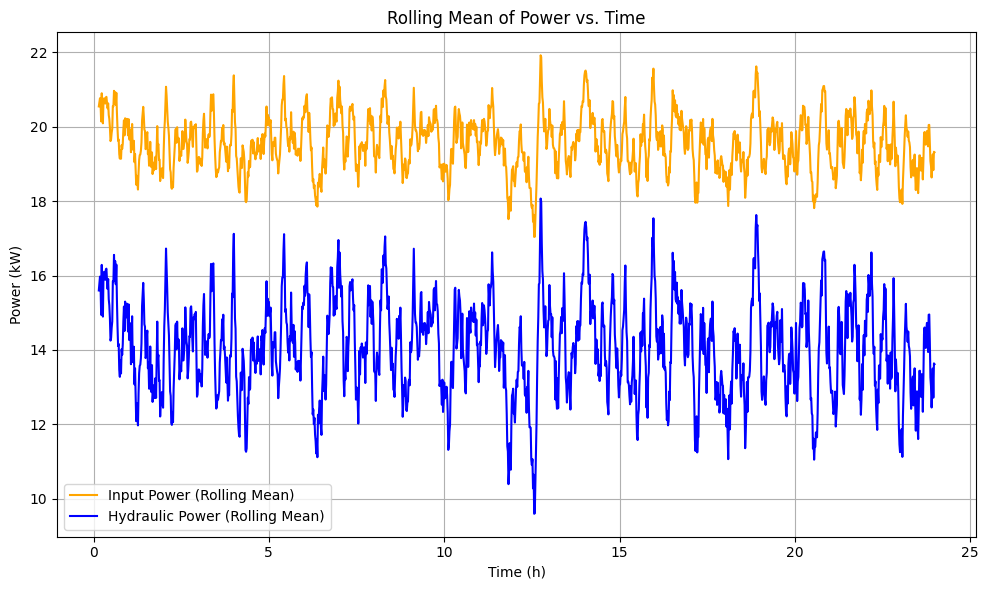

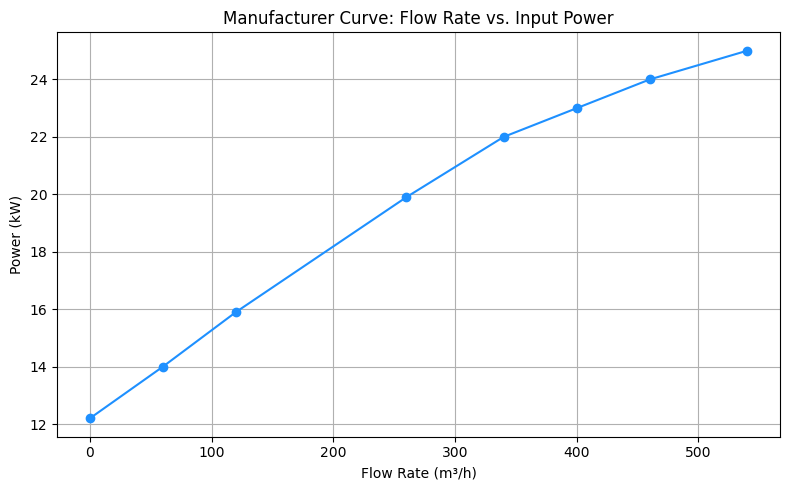

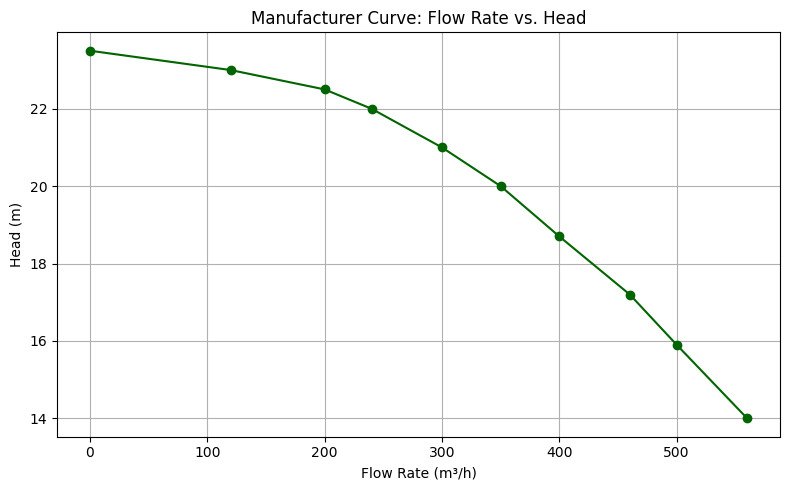

<Figure size 800x500 with 0 Axes>

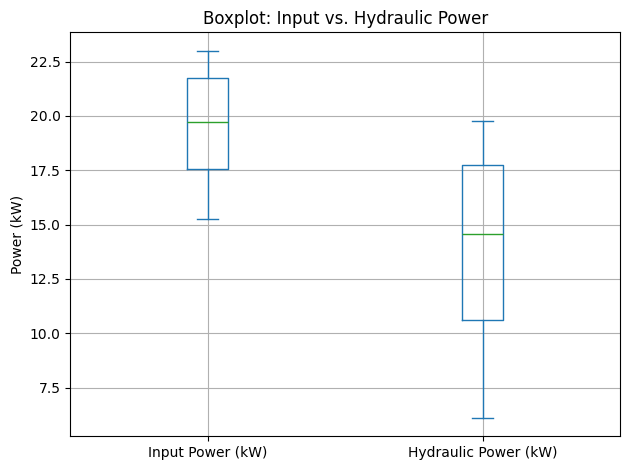

In [2]:
# @author: DziarnowskiNico(060)

# Description:
# This script analyzes pump performance using time-resolved flow rate data.
# It compares measured performance against manufacturer specifications by:
# - Interpolating pump head and input power from characteristic curves
# - Calculating hydraulic and input energy
# - Determining pump efficiency and losses
# - Visualizing results through time plots, characteristic curves, and boxplots

import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# ============================================
# Step 1: Load measurement data
# ============================================

# Read measurement data containing timestamps and volume flow [m³/h]
# File must be in the working directory
df = pd.read_csv("volume_flow_data.csv")


# Convert timestamp column to datetime format
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# Convert volume flow from m³/h to m³/s
df["Q_m3s"] = df["Volume Flow (m^3/h)"] / 3600.0

# Define time interval (each row = 1 minute = 1/60 hours)
time_interval_hours = 1 / 60.0

# ============================================
# Step 2: Digitized manufacturer data (from datasheet plots)
# ============================================

# Head curve: Flow rate vs. delivery head (H)
head_curve = {
    "Flow Rate (m^3/h)": [0, 120, 200, 240, 300, 350, 400, 460, 500, 560],
    "Head (m)": [23.5, 23.0, 22.5, 22.0, 21.0, 20.0, 18.7, 17.2, 15.9, 14.0]
}
df_head = pd.DataFrame(head_curve)

# Power curve: Flow rate vs. input power (P_in)
power_curve = {
    "Flow Rate (m^3/h)": [0, 60, 120, 260, 340, 400, 460, 540],
    "Power (kW)": [12.2, 14.0, 15.9, 19.9, 22.0, 23.0, 24.0, 25.0]
}
df_power = pd.DataFrame(power_curve)

# Create interpolation functions from the digitized curves
interp_head = interp1d(
    df_head["Flow Rate (m^3/h)"],
    df_head["Head (m)"],
    kind='linear',
    fill_value="extrapolate"
)

interp_power = interp1d(
    df_power["Flow Rate (m^3/h)"],
    df_power["Power (kW)"],
    kind='linear',
    fill_value="extrapolate"
)


# ============================================
# Step 3: Calculate interpolated values and energy
# ============================================

# Constants
rho = 969  # Fluid density in kg/m³ (from datasheet)
g = 9.81   # Gravitational acceleration in m/s²

# Apply interpolated values based on measured flow rate
df["Head (m)"] = interp_head(df["Volume Flow (m^3/h)"])
df["Input Power (kW)"] = interp_power(df["Volume Flow (m^3/h)"])

# Calculate input energy per time step
df["Input Energy (kWh)"] = df["Input Power (kW)"] * time_interval_hours

# Calculate hydraulic power and energy per time step
df["Hydraulic Power (W)"] = rho * g * df["Head (m)"] * df["Q_m3s"]
df["Hydraulic Power (kW)"] = df["Hydraulic Power (W)"] / 1000
df["Hydraulic Energy (kWh)"] = df["Hydraulic Power (kW)"] * time_interval_hours

# ============================================
# Step 4: Summary results
# ============================================

# Sum over all time steps to get total energy values
total_input_energy = df["Input Energy (kWh)"].sum()
total_hydraulic_energy = df["Hydraulic Energy (kWh)"].sum()

# Calculate average pump efficiency and energy losses
efficiency_avg = (total_hydraulic_energy / total_input_energy) * 100
energy_loss = total_input_energy - total_hydraulic_energy

# Print results
print(f"(Ex. 1) Total Input Energy: {total_input_energy:.2f} kWh")
print(f"(Ex. 2) Average Pump Efficiency: {efficiency_avg:.2f} %")
print(f"(Ex. 3) Unused Energy (Losses): {energy_loss:.2f} kWh")
print(f"(Ex. 4) Total Hydraulic Energy: {total_hydraulic_energy:.2f} kWh")

# ============================================
# Step 5: Visualizations
# ============================================

# 5.1: Rolling Mean of Power vs. Time

# Create time axis in hours
df["Time (h)"] = df.index * time_interval_hours

# Rolling mean window size (10 time steps = ~10 minutes)
window_size = 10
df["Input Power (Rolling Mean)"] = (
    df["Input Power (kW)"].rolling(window=window_size).mean()
)
df["Hydraulic Power (Rolling Mean)"] = (
    df["Hydraulic Power (kW)"].rolling(window=window_size).mean()
)

# Plot rolling mean of input and hydraulic power
plt.figure(figsize=(10, 6))
plt.plot(
    df["Time (h)"],
    df["Input Power (Rolling Mean)"],
    label="Input Power (Rolling Mean)",
    color="orange"
)
plt.plot(
    df["Time (h)"],
    df["Hydraulic Power (Rolling Mean)"],
    label="Hydraulic Power (Rolling Mean)",
    color="blue"
)
plt.xlabel("Time (h)")
plt.ylabel("Power (kW)")
plt.title("Rolling Mean of Power vs. Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 5.2: Manufacturer curve – Flow Rate vs. Input Power
plt.figure(figsize=(8, 5))
plt.plot(df_power["Flow Rate (m^3/h)"], df_power["Power (kW)"],
         marker="o", linestyle="-", color="dodgerblue")
plt.xlabel("Flow Rate (m³/h)")
plt.ylabel("Power (kW)")
plt.title("Manufacturer Curve: Flow Rate vs. Input Power")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5.3: Manufacturer curve – Flow Rate vs. Head
plt.figure(figsize=(8, 5))
plt.plot(df_head["Flow Rate (m^3/h)"], df_head["Head (m)"],
         marker="o", linestyle="-", color="darkgreen")
plt.xlabel("Flow Rate (m³/h)")
plt.ylabel("Head (m)")
plt.title("Manufacturer Curve: Flow Rate vs. Head")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5.4: Boxplot – Input vs. Hydraulic Power Distribution
plt.figure(figsize=(8, 5))
df[["Input Power (kW)", "Hydraulic Power (kW)"]].plot(kind="box", grid=True)
plt.title("Boxplot: Input vs. Hydraulic Power")
plt.ylabel("Power (kW)")
plt.tight_layout()
plt.show()